### Mounting, imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
dataset_path = '/content/drive/My Drive/NLP/dataset/'

Using TensorFlow backend.


### Shared Functions

In [0]:
# load and preprocess function
def load_data(dataset_path):
  pos = pd.read_csv(dataset_path + 'rt-polarity.pos', sep='\t', header=None, names=['Sentiment'])
  neg = pd.read_csv(dataset_path + 'rt-polarity.neg', sep='\t', header=None, names=['Sentiment'])
  pos['Target'] = 1
  neg['Target'] = 0

  X_full = pd.concat((pos, neg), axis=0, ignore_index=True)
  X_full = shuffle(X_full)

  y = X_full.Target
  X_full.drop(['Target'], axis=1, inplace=True)

  X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.15)
  return X_full, X_train, X_test, y_train, y_test

# Create and train tokenizer
def tokenizer(X):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(X['Sentiment'])
  return tokenizer

# Tokenize given matrix
def data_tokenize(X, tokenizer):
  X_emb = tokenizer.texts_to_matrix(X['Sentiment'])
  return X_emb

# Printing out model accuracy, confusion matrix, plotting heatmap
def evaluate_model(y_true, predictions):
  cm = confusion_matrix(y_true, predictions)
  print("\nConfusion matrix: \n", cm)
  print("")
  cr = classification_report(y_true, predictions)
  print("Classification report: \n", cr)
  print("")
  sns.heatmap(cm, annot=True)
  plt.show()
  
# Calculate our predictions accuracy
def accuracy(y_true, predictions):
  accuracy = (predictions == y_true).mean()*100
  return accuracy

# Naive Bayes

## Functions

In [0]:
# Calculate Naive Bayes algorithm parameters
def calculations(X, y):
  p = X[y==1].sum(0) + 1
  q = X[y==0].sum(0) + 1
  r = np.log((p/p.sum())/(q/q.sum()))
  b = np.log(len(p) / len(q))
  return r, b

# Predict targets of given matrix using learned parameters
def predict_Bayes(X, r, b):
  pre_preds = np.dot(X, r.T) + b
  predictions= pre_preds.T > 0
  return predictions

## Data

In [6]:
# loading, preprocessing data
X_full, X_train, X_test, y_train, y_test = load_data(dataset_path)

X_train.head()

,Sentiment
7803,"trivial where it should be profound , and hype..."
6396,a jumbled fantasy comedy that did not figure o...
1908,"strip it of all its excess debris , and you'd ..."
2143,the film just might turn on many people to ope...
269,it's solid and affecting and exactly as though...


## Model

In [0]:
# creating tokenizer for entries tokenization, fitting on full data
tokenizer_bayes = tokenizer(X_full)

# tokenize training data
X_train_emb = data_tokenize(X_train, tokenizer_bayes)

# calculating Naive Bayes model parameters
r, b = calculations(X_train_emb, y_train)

# tokenize test data
X_test_emb = data_tokenize(X_test, tokenizer_bayes)

# predicting test data targets
predictions_bayes = predict_Bayes(X_test_emb, r, b)

# calculating our model accuracy
accuracy = accuracy(predictions_bayes, y_test)

## Results

Test accuracy: 77.0

Confusion matrix: 
 [[635 172]
 [196 597]]

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.79      0.78       807
           1       0.78      0.75      0.76       793

    accuracy                           0.77      1600
   macro avg       0.77      0.77      0.77      1600
weighted avg       0.77      0.77      0.77      1600




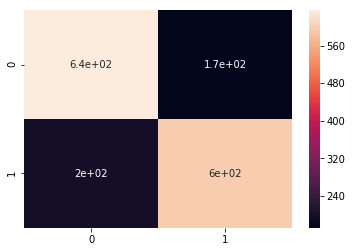

In [8]:
# printing accuracy
print('Test accuracy: {}'.format(accuracy))

# model evaluation (confusion matrix, heatmap)
evaluate_model(y_test, predictions_bayes)

# Logistic regression

## Functions

In [0]:
# Create logistic regression model and try 
# different hyperparameters for better performance
def create_model(C_range, penalties):
  grid={"C": C_range, "penalty": penalties}
  logreg = LogisticRegression()
  model = GridSearchCV(logreg, grid,cv=10)
  return model

## Data

In [10]:
# loading, preprocessing data
X_full, X_train, X_test, y_train, y_test = load_data(dataset_path)

X_train.head()

,Sentiment
7981,""" the kid stays in the picture "" is a great s..."
5506,i found myself growing more and more frustrate...
7414,"it may be a prize winner , but teacher is a bo..."
1993,an absorbing and unsettling psychological dram...
3959,"a b-movie you can sit through , enjoy on a cer..."


## Model

In [0]:
# creating tokenizer for entries tokenization, fitting on full data
tokenizer_logistic = tokenizer(X_full)

# tokenize training data and testing data
X_train_emb = data_tokenize(X_train, tokenizer_logistic)
X_test_emb = data_tokenize(X_test, tokenizer_logistic)

# create a model with grid search for optimal hyperparameters
model = create_model(np.logspace(-3,3,7), ["l1","l2"])

# train model
model.fit(X_train_emb, y_train)

# make predictions on test data
predictions_logistic = model.predict(X_test_emb)


## Results

Best parameters are: {'C': 1.0, 'penalty': 'l2'}
Accuracy: 76.34076362833811 %

Confusion matrix: 
 [[597 191]
 [182 630]]

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.76      0.76       788
           1       0.77      0.78      0.77       812

    accuracy                           0.77      1600
   macro avg       0.77      0.77      0.77      1600
weighted avg       0.77      0.77      0.77      1600




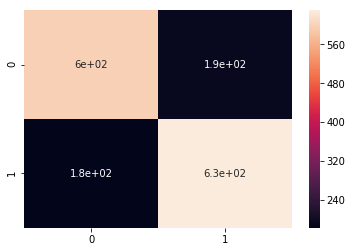

In [14]:
# best parameters
print('Best parameters are: {}'.format(model.best_params_))

# printing accuracy
print('Accuracy: {} %'.format(model.best_score_*100))

# model evaluation (confusion matrix, heatmap)
evaluate_model(y_test, predictions_logistic)